RMSE for RLS forecast (Yhat1) by horizon:
k1    250.260415
k2    336.364454
k3    364.007191
k4    368.325785
k5    368.200132
dtype: float64
RMSE for Persistence forecast (YhatP) by horizon:
k1     469.876287
k2     775.435030
k3     990.359989
k4    1148.590635
k5    1259.074585
dtype: float64


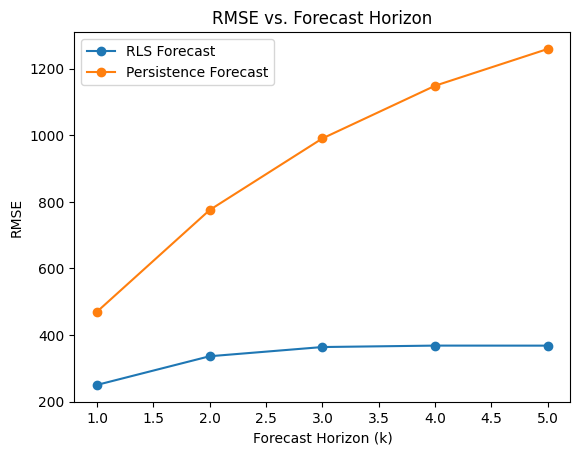

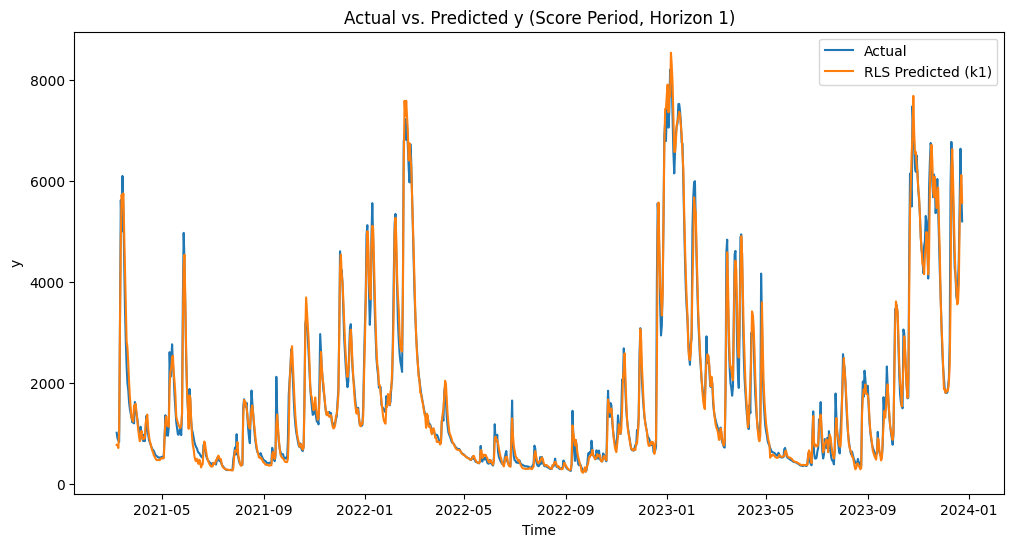

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Helper Functions
# -------------------------------

def low_pass(series, a1):
    """
    Applies an exponential (low-pass) filter to a series.
    Formula: s[t] = a1 * s[t-1] + (1 - a1) * x[t]
    """
    return series.ewm(alpha=1-a1, adjust=False).mean()

def persistence(df, horizons):
    """
    Computes a persistence forecast that always uses the previous day's inflow.
    For every horizon, the forecast is simply the previous day's inflow (y(t-1)).
    """
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        forecasts[f'k{k}'] = df['y'].shift(1)  # always use y(t-1)
    return forecasts

def score(residuals, mask=None):
    """
    Computes RMSE for a given residual Series.
    If a mask is provided, only those rows are used.
    """
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def plot_rmse(rmse_dict, horizons):
    """
    Plots RMSE as a function of forecast horizon.
    rmse_dict: dictionary with keys as model names and values as RMSE Series (indexed by horizon, e.g. 'k1', 'k2', etc.)
    horizons: list of horizon values (e.g., [1, 2, 3, 4, 5])
    """
    plt.figure()
    for model_name, rmse in rmse_dict.items():
        plt.plot(horizons, rmse.values, marker='o', label=model_name)
    plt.xlabel("Forecast Horizon (k)")
    plt.ylabel("RMSE")
    plt.title("RMSE vs. Forecast Horizon")
    plt.legend()
    plt.show()

def rls_fit(X, y, lam=0.9, delta=1000):
    """
    Simple recursive least squares (RLS) algorithm.
    X: design matrix (2D numpy array) with each row as an observation.
    y: target vector (1D numpy array).
    Returns the final coefficients and a vector of fitted values (yhat).
    """
    n_obs, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    yhat = np.empty(n_obs)
    yhat[:] = np.nan
    for t in range(n_obs):
        x_t = X[t, :].reshape(-1, 1)
        if np.any(np.isnan(x_t)):
            continue
        denom = lam + (x_t.T @ P @ x_t)[0, 0]
        K = (P @ x_t) / denom
        if np.isnan(y[t]):
            continue
        error = y[t] - (x_t.T @ theta.reshape(-1, 1))[0, 0]
        theta = theta + (K.flatten() * error)
        P = (P - K @ x_t.T @ P) / lam
        yhat[t] = (X[t, :] @ theta)
    return theta, yhat

def fit_rls_forecast(df, lam=0.9, a1=0.9, horizons=[1,2,3,4,5]):
    """
    For each forecast horizon k, builds a design matrix with:
      - A bias term (1),
      - The inflow predictor: previous day's inflow (df['y'].shift(1)),
      - Weather predictors: temperature and precipitation for the target day.
        These are obtained by shifting the weather series by -(k-1).
    The target is the inflow on the forecast day: df['y'] shifted by -(k-1).
    Returns:
      - coeffs: a dictionary of final coefficients for each horizon,
      - forecasts: a DataFrame with forecasts for each horizon.
    """
    forecasts = pd.DataFrame(index=df.index)
    coeffs = {}
    for k in horizons:
        bias = pd.Series(1, index=df.index, name='bias')
        inflow_pred = df['y'].shift(1).rename('inflow')
        temp_pred = df['temp_mean_daily'].shift(-(k-1)).rename('temp')
        precip_pred = df['precip_total_daily'].shift(-(k-1))
        precip_pred_lp = low_pass(precip_pred, a1).rename('precip')
        X = pd.concat([bias, inflow_pred, temp_pred, precip_pred_lp], axis=1)
        y_target = df['y'].shift(-(k-1))
        valid = X.notna().all(axis=1) & y_target.notna()
        X_valid = X.loc[valid].to_numpy()
        y_valid = y_target.loc[valid].to_numpy()
        theta, yhat = rls_fit(X_valid, y_valid, lam=lam, delta=1000)
        coeffs[f'k{k}'] = theta
        yhat_full = pd.Series(data=np.nan, index=df.index)
        yhat_full.loc[valid] = yhat
        forecasts[f'k{k}'] = yhat_full
    return coeffs, forecasts

# -------------------------------
# Main Script
# -------------------------------

# 1. Load the dataset (adjust the path as needed)
data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
D = pd.read_csv(data_path)

# 2. Convert 'time' to datetime and set the target variable 'y'
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']

# 3. Data cleaning
temp_mask = D['temp_mean_daily'] > 35
D.loc[temp_mask, 'temp_mean_daily'] = D['temp_mean_daily'].shift(1)[temp_mask]
precip_mask = D['precip_total_daily'] > 100
D.loc[precip_mask, 'precip_total_daily'] = 0

# 4. Define forecast horizons.
horizons = [1, 2, 3, 4, 5]

# 5. Work with a datetime-indexed version.
D_time_indexed = D.set_index('t')

# 6. Define the score period as the last 1023 days.
scoreperiod = D_time_indexed.index[-1023:]

# 7. Fit the RLS forecasting model for all horizons.
coeffs, Yhat1 = fit_rls_forecast(D, lam=0.9, a1=0.9, horizons=horizons)
Yhat1.index = D_time_indexed.index  # Align forecast index with datetime index

# 8. Compute persistence forecasts.
# Here, the persistence forecast always uses y(t-1) for every horizon.
YhatP = persistence(D_time_indexed, horizons)

# 9. Compute RMSE for each forecast method over the score period.
# For persistence, compare y(t-1) with the appropriate target for each horizon.
rmse_YhatP = {}
for k in horizons:
    # For horizon k, the target is y shifted by -(k-1)
    target = D_time_indexed['y'].shift(-(k-1))
    forecast = YhatP[f'k{k}']
    # Restrict to the score period
    mask = D_time_indexed.index.isin(scoreperiod)
    rmse_YhatP[f'k{k}'] = score(forecast - target, mask=mask)
rmse_YhatP = pd.Series(rmse_YhatP)

# For the RLS forecast, the RMSE is computed in the same way as before.
rmse_Yhat1 = {}
for k in horizons:
    target = D_time_indexed['y'].shift(-(k-1))
    forecast = Yhat1[f'k{k}']
    mask = D_time_indexed.index.isin(scoreperiod)
    rmse_Yhat1[f'k{k}'] = score(forecast - target, mask=mask)
rmse_Yhat1 = pd.Series(rmse_Yhat1)

# Print RMSE values.
print("RMSE for RLS forecast (Yhat1) by horizon:")
print(rmse_Yhat1)
print("RMSE for Persistence forecast (YhatP) by horizon:")
print(rmse_YhatP)

# 10. Plot RMSE vs. forecast horizon.
rmse_dict = {'RLS Forecast': rmse_Yhat1, 'Persistence Forecast': rmse_YhatP}
plot_rmse(rmse_dict, horizons)

# 11. Plot actual vs. predicted values for the score period (for horizon k=1).
plt.figure(figsize=(12, 6))
score_data = D_time_indexed.loc[scoreperiod]
plt.plot(score_data.index, score_data['y'], label='Actual')
plt.plot(score_data.index, Yhat1.loc[score_data.index, 'k1'], label='RLS Predicted (k1)')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Actual vs. Predicted y (Score Period, Horizon 1)')
plt.legend()
plt.show()

## Extreme occurences

Threshold for top 10% extreme events: 4611.924000000001
RMSE for RLS forecast (Yhat1) on extreme events by horizon:
k1    499.755389
k2    731.065796
k3    797.305758
k4    801.331779
k5    799.794690
dtype: float64
RMSE for Persistence forecast (YhatP) on extreme events by horizon:
k1     857.896517
k2    1617.902392
k3    2079.848243
k4    2341.873536
k5    2535.227837
dtype: float64


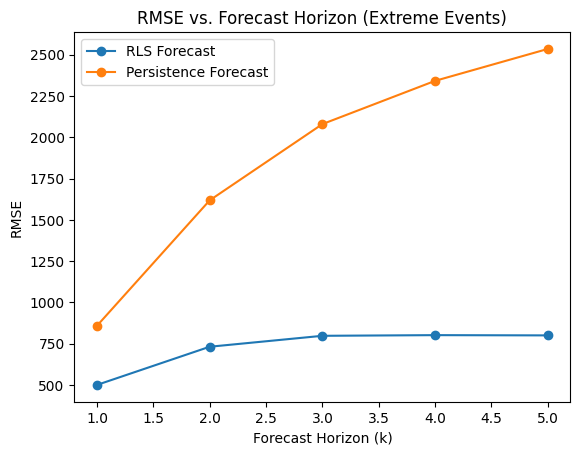

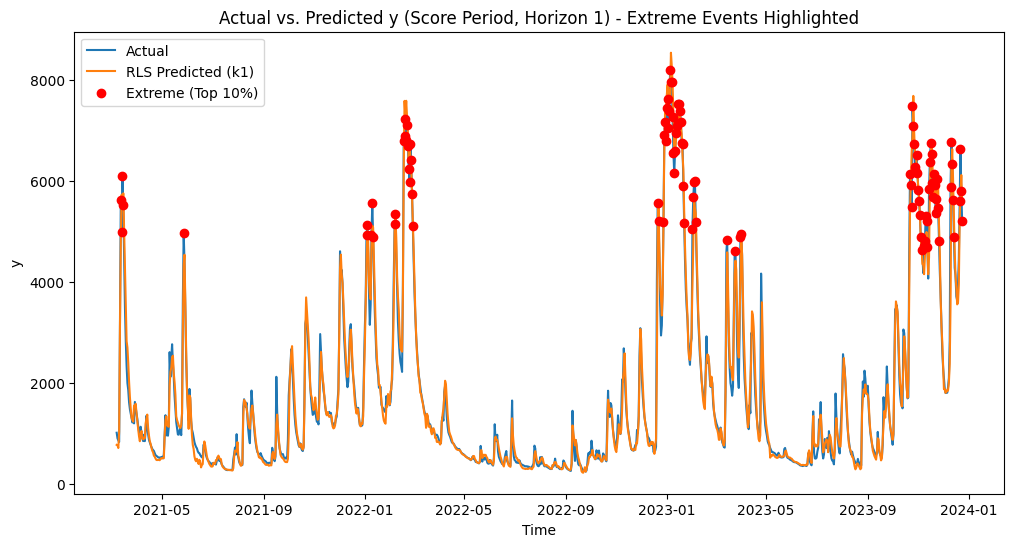

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Helper Functions
# -------------------------------

def low_pass(series, a1):
    """
    Applies an exponential (low-pass) filter to a series.
    Formula: s[t] = a1 * s[t-1] + (1 - a1) * x[t]
    """
    return series.ewm(alpha=1-a1, adjust=False).mean()

def persistence(df, horizons):
    """
    Computes a persistence forecast that always uses the previous day's inflow.
    For every horizon, the forecast is simply the previous day's inflow (y(t-1)).
    """
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        forecasts[f'k{k}'] = df['y'].shift(1)  # always use y(t-1)
    return forecasts

def score(residuals, mask=None):
    """
    Computes RMSE for a given residual Series.
    If a mask is provided, only those rows are used.
    """
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def plot_rmse(rmse_dict, horizons):
    """
    Plots RMSE as a function of forecast horizon.
    rmse_dict: dictionary with keys as model names and values as RMSE Series (indexed by horizon, e.g. 'k1', 'k2', etc.)
    horizons: list of horizon values (e.g., [1, 2, 3, 4, 5])
    """
    plt.figure()
    for model_name, rmse in rmse_dict.items():
        plt.plot(horizons, rmse.values, marker='o', label=model_name)
    plt.xlabel("Forecast Horizon (k)")
    plt.ylabel("RMSE")
    plt.title("RMSE vs. Forecast Horizon (Extreme Events)")
    plt.legend()
    plt.show()

def rls_fit(X, y, lam=0.9, delta=1000):
    """
    Simple recursive least squares (RLS) algorithm.
    X: design matrix (2D numpy array) with each row as an observation.
    y: target vector (1D numpy array).
    Returns the final coefficients and a vector of fitted values (yhat).
    """
    n_obs, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    yhat = np.empty(n_obs)
    yhat[:] = np.nan
    for t in range(n_obs):
        x_t = X[t, :].reshape(-1, 1)
        if np.any(np.isnan(x_t)):
            continue
        denom = lam + (x_t.T @ P @ x_t)[0, 0]
        K = (P @ x_t) / denom
        if np.isnan(y[t]):
            continue
        error = y[t] - (x_t.T @ theta.reshape(-1, 1))[0, 0]
        theta = theta + (K.flatten() * error)
        P = (P - K @ x_t.T @ P) / lam
        yhat[t] = (X[t, :] @ theta)
    return theta, yhat

def fit_rls_forecast(df, lam=0.9, a1=0.9, horizons=[1,2,3,4,5]):
    """
    For each forecast horizon k, builds a design matrix with:
      - A bias term (1),
      - The inflow predictor: previous day's inflow (df['y'].shift(1)),
      - Weather predictors: temperature and precipitation for the target day.
        These are obtained by shifting the weather series by -(k-1).
    The target is the inflow on the forecast day: df['y'] shifted by -(k-1).
    Returns:
      - coeffs: a dictionary of final coefficients for each horizon,
      - forecasts: a DataFrame with forecasts for each horizon.
    """
    forecasts = pd.DataFrame(index=df.index)
    coeffs = {}
    for k in horizons:
        bias = pd.Series(1, index=df.index, name='bias')
        inflow_pred = df['y'].shift(1).rename('inflow')
        temp_pred = df['temp_mean_daily'].shift(-(k-1)).rename('temp')
        precip_pred = df['precip_total_daily'].shift(-(k-1))
        precip_pred_lp = low_pass(precip_pred, a1).rename('precip')
        X = pd.concat([bias, inflow_pred, temp_pred, precip_pred_lp], axis=1)
        y_target = df['y'].shift(-(k-1))
        valid = X.notna().all(axis=1) & y_target.notna()
        X_valid = X.loc[valid].to_numpy()
        y_valid = y_target.loc[valid].to_numpy()
        theta, yhat = rls_fit(X_valid, y_valid, lam=lam, delta=1000)
        coeffs[f'k{k}'] = theta
        yhat_full = pd.Series(data=np.nan, index=df.index)
        yhat_full.loc[valid] = yhat
        forecasts[f'k{k}'] = yhat_full
    return coeffs, forecasts

# -------------------------------
# Main Script
# -------------------------------

# 1. Load the dataset (adjust the path as needed)
data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
D = pd.read_csv(data_path)

# 2. Convert 'time' to datetime and set the target variable 'y'
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']

# 3. Data cleaning
temp_mask = D['temp_mean_daily'] > 35
D.loc[temp_mask, 'temp_mean_daily'] = D['temp_mean_daily'].shift(1)[temp_mask]
precip_mask = D['precip_total_daily'] > 100
D.loc[precip_mask, 'precip_total_daily'] = 0

# 4. Define forecast horizons.
horizons = [1, 2, 3, 4, 5]

# 5. Work with a datetime-indexed version.
D_time_indexed = D.set_index('t')

# 6. Define the score period as the last 1023 days.
scoreperiod = D_time_indexed.index[-1023:]

# 7. Compute the threshold for the top 10% of values within the score period.
threshold = D_time_indexed.loc[scoreperiod, 'y'].quantile(0.9)
print("Threshold for top 10% extreme events:", threshold)

# 8. Fit the RLS forecasting model for all horizons.
coeffs, Yhat1 = fit_rls_forecast(D, lam=0.9, a1=0.9, horizons=horizons)
Yhat1.index = D_time_indexed.index  # Align forecast index with datetime index

# 9. Compute persistence forecasts.
# Here, the persistence forecast always uses y(t-1) for every horizon.
YhatP = persistence(D_time_indexed, horizons)

# 10. Compute RMSE for each forecast method over the extreme events within the score period.
# For each horizon, we compare the forecast with the target but only for days when the target is in the top 10%.
rmse_YhatP = {}
for k in horizons:
    # For horizon k, the target is y shifted by -(k-1)
    target = D_time_indexed['y'].shift(-(k-1))
    forecast = YhatP[f'k{k}']
    mask = D_time_indexed.index.isin(scoreperiod) & (target >= threshold)
    rmse_YhatP[f'k{k}'] = score(forecast - target, mask=mask)
rmse_YhatP = pd.Series(rmse_YhatP)

rmse_Yhat1 = {}
for k in horizons:
    target = D_time_indexed['y'].shift(-(k-1))
    forecast = Yhat1[f'k{k}']
    mask = D_time_indexed.index.isin(scoreperiod) & (target >= threshold)
    rmse_Yhat1[f'k{k}'] = score(forecast - target, mask=mask)
rmse_Yhat1 = pd.Series(rmse_Yhat1)

# Print RMSE values for extreme events.
print("RMSE for RLS forecast (Yhat1) on extreme events by horizon:")
print(rmse_Yhat1)
print("RMSE for Persistence forecast (YhatP) on extreme events by horizon:")
print(rmse_YhatP)

# 11. Plot RMSE vs. forecast horizon for extreme events.
rmse_dict = {'RLS Forecast': rmse_Yhat1, 'Persistence Forecast': rmse_YhatP}
plot_rmse(rmse_dict, horizons)

# 12. Plot actual vs. predicted values for the score period (for horizon k=1), highlighting extreme events.
plt.figure(figsize=(12, 6))
score_data = D_time_indexed.loc[scoreperiod]
# Identify indices in the score period where the target is extreme
extreme_mask = score_data['y'] >= threshold
plt.plot(score_data.index, score_data['y'], label='Actual')
plt.plot(score_data.index, Yhat1.loc[score_data.index, 'k1'], label='RLS Predicted (k1)')
plt.scatter(score_data.index[extreme_mask], score_data['y'][extreme_mask], 
            color='red', label='Extreme (Top 10%)', zorder=5)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Actual vs. Predicted y (Score Period, Horizon 1) - Extreme Events Highlighted')
plt.legend()
plt.show()
